**Deep learning for timeseries**


In [1]:
# Download the jena_climate_2009_2016.csv.zip file from AWS S3
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

# Unzip the jena_climate_2009_2016.csv.zip file
!unzip jena_climate_2009_2016.csv.zip


--2024-04-04 01:38:43--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.194.152, 52.216.214.152, 52.217.134.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.194.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.5MB/s    in 0.3s    

2024-04-04 01:38:43 (43.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Importing the data file**

In [2]:
#Importing csv
import os
fname = os.path.join("jena_climate_2009_2016.csv")

In [3]:
#Reading Data from file
with open(fname) as f:
    data = f.read()

In [4]:
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
# Split the data into lines
lines = data.split("\n")
# Get the header row
header = lines[0].split(",")
# Remove the header row from the list of lines
lines = lines[1:]
# Print the header row
print(header)
# Print the number of lines in the data
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [6]:
import numpy as np

# Create a NumPy array to store the temperature data
temperature = np.zeros((len(lines),))

# Create a NumPy array to store the raw data
raw_data = np.zeros((len(lines), len(header) - 1))

# Iterate over the lines in the data
for i, line in enumerate(lines):

    # Split the line into a list of values
    values = [float(x) for x in line.split(",")[1:]]

    # Store the temperature in the temperature array
    temperature[i] = values[1]

    # Store the raw data in the raw_data array
    raw_data[i, :] = values[:]


In [7]:
temperature[:5]

array([-8.02, -8.41, -8.51, -8.31, -8.27])

In [8]:
view = pd.DataFrame(temperature)
view.describe()

,0
count,420451.000000
mean,9.448567
std,8.423685
min,-23.010000
25%,3.360000
50%,9.410000
75%,15.470000
max,37.280000


**Plotting the temperature timeseries**

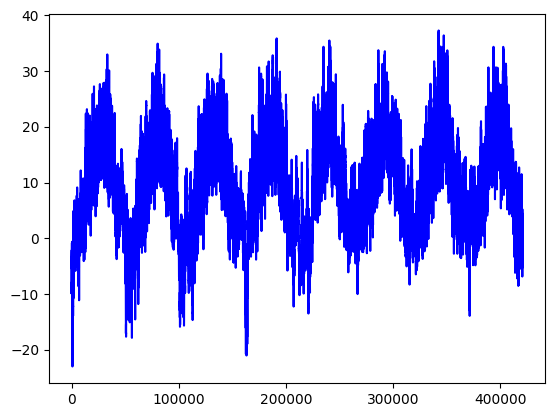

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)), temperature, color='blue')



**Plotting the first 15 days of the temperature timeseries**

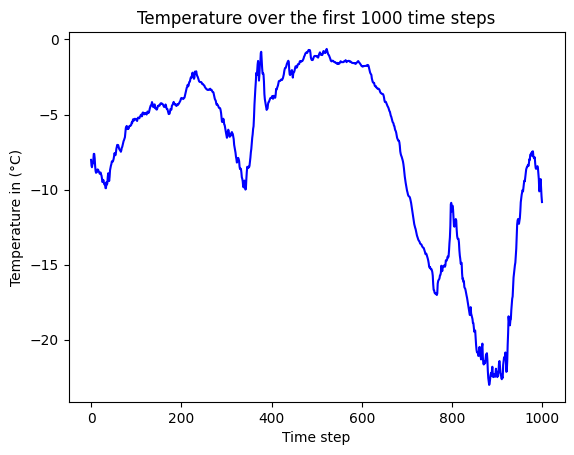

In [10]:
## Plot the first 1000 temperature values
plt.plot(range(1000), temperature[:1000], color='blue')
# Set the x-axis label
plt.xlabel("Time step")

# Set the y-axis label
plt.ylabel("Temperature in (°C)")

# Set the title of the plot
plt.title("Temperature over the first 1000 time steps")

# Display the plot
plt.show()


**Computing the number of samples we'll use for each data split**

In [11]:
# Split the data into train, validation, and test sets
num_train_samples = int(0.5 * len(raw_data))  # 50% of the data for training
num_val_samples = int(0.25 * len(raw_data))  # 25% of the data for validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples  # The remaining 25% of the data for testing


**Preparing the data
Normalizing the data**

In [12]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [13]:
#Instantiating datasets for training, validation, and testing
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [14]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],  # The input data
    targets=temperature[delay:],  # The target data
    sampling_rate=sampling_rate,  # The sampling rate
    sequence_length=sequence_length,  # The length of the sequences
    shuffle=True,  # Whether to shuffle the data
    batch_size=batch_size,  # The batch size
    start_index=0,  # The start index
    end_index=num_train_samples)  # The end index


In [15]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],  # The input data
    targets=temperature[delay:],  # The target data
    sampling_rate=sampling_rate,  # The sampling rate
    sequence_length=sequence_length,  # The length of the sequences
    shuffle=True,  # Whether to shuffle the data
    batch_size=batch_size,  # The batch size
    start_index=num_train_samples,  # The start index
    end_index=num_train_samples + num_val_samples)  # The end index


In [16]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],  # The input data
    targets=temperature[delay:],  # The target data
    sampling_rate=sampling_rate,  # The sampling rate
    sequence_length=sequence_length,  # The length of the sequences
    shuffle=True,  # Whether to shuffle the data
    batch_size=batch_size,  # The batch size
    start_index=num_train_samples + num_val_samples,  # The start index
    # Set the end index to None so that the dataset will contain all of the remaining samples.
    end_index=None)


In [17]:
# Iterate over the first sample in the train dataset
for samples, targets in train_dataset:
    # Print the shape of the samples and targets
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)

    # Break out of the loop after the first iteration
    break


samples shape: (256, 120, 14)
targets shape: (256,)


**common-sense, non-machine-learning baseline**

In [18]:

#Computing the common-sense baseline MAE
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [19]:
from tensorflow import keras
from keras import layers

**Training and evaluating a densely connected model**

In [20]:
#Training and evaluating a densely connected model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 10s 12ms/step - loss: 13.9144 - mae: 2.8730 - val_loss: 10.3768 - val_mae: 2.5313
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 9.7026 - mae: 2.4543 - val_loss: 11.0113 - val_mae: 2.6236
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 8.8999 - mae: 2.3521 - val_loss: 12.0925 - val_mae: 2.7576
Epoch 4/10
819/819 [==============================] - 10s 13ms/step - loss: 8.3149 - mae: 2.2734 - val_loss: 10.1688 - val_mae: 2.5129
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.9362 - mae: 2.2208 - val_loss: 12.7303 - val_mae: 2.8350
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 7.6128 - mae: 2.1749 - val_loss: 11.5131 - val_mae: 2.6831
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.4133 - mae: 2.1450 - val_loss: 10.6766 - val_mae: 2.5875
Epoch 8/10
819/819 [==============================] - 9s 1

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26913 (105.13 KB)
Trainable params: 26913 (105.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


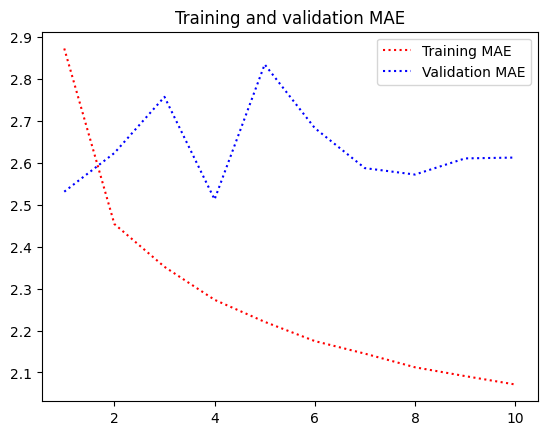

In [23]:

import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()


**1D Convolution model with 10 epoch**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 19ms/step - loss: 21.2953 - mae: 3.6327 - val_loss: 14.9089 - val_mae: 3.0525
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 15.1318 - mae: 3.0820 - val_loss: 14.3927 - val_mae: 2.9858
Epoch 3/10
819/819 [==============================] - 16s 19ms/step - loss: 13.8257 - mae: 2.9422 - val_loss: 14.2118 - val_mae: 2.9439
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 12.9649 - mae: 2.8481 - val_loss: 16.9019 - val_mae: 3.2432
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 12.3070 - mae: 2.7754 - val_loss: 15.8101 - val_mae: 3.1372
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 11.8662 - mae: 2.7250 - val_loss: 15.0605 - val_mae: 3.0174
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 11.4238 - mae: 2.6710 - val_loss: 14.7357 - val_mae: 2.9805
Epoch 8/10
819/819 [============================

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

In [26]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


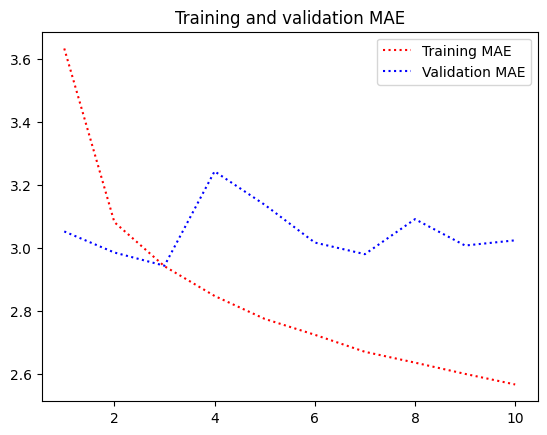

In [27]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**The training and validation losses are decreasing over time, which suggests that the model is learning.
The validation loss is slightly higher than the training loss, which is normal. It is important to monitor the validation loss to make sure that the model is not overfitting the training data.
The test MAE is somewhat higher than the validation MAE, which suggests that the model is not generalizing perfectly to unseen data. This could be due to a number of factors, such as noise in the data or the model being undertrained.**


**A Simple RNN**

In [28]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 20s 24ms/step - loss: 138.4978 - mae: 9.6699 - val_loss: 143.9265 - val_mae: 9.8941
Epoch 2/10
819/819 [==============================] - 20s 24ms/step - loss: 136.3981 - mae: 9.5580 - val_loss: 143.7205 - val_mae: 9.8675
Epoch 3/10
819/819 [==============================] - 21s 26ms/step - loss: 136.2857 - mae: 9.5466 - val_loss: 143.6158 - val_mae: 9.8568
Epoch 4/10
819/819 [==============================] - 20s 24ms/step - loss: 136.2269 - mae: 9.5429 - val_loss: 143.6168 - val_mae: 9.8579
Epoch 5/10
819/819 [==============================] - 20s 25ms/step - loss: 136.1779 - mae: 9.5398 - val_loss: 143.5821 - val_mae: 9.8516
Epoch 6/10
819/819 [==============================] - 19s 24ms/step - loss: 136.1405 - mae: 9.5353 - val_loss: 143.5510 - val_mae: 9.8502
Epoch 7/10
819/819 [==============================] - 20s 24ms/step - loss: 136.1283 - mae: 9.5352 - val_loss: 143.5402 - val_mae: 9.8485
Epoch 8/10
819/819 [==============

In [29]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 14)]        0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                496       
                                                                 
Total params: 496 (1.94 KB)
Trainable params: 496 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


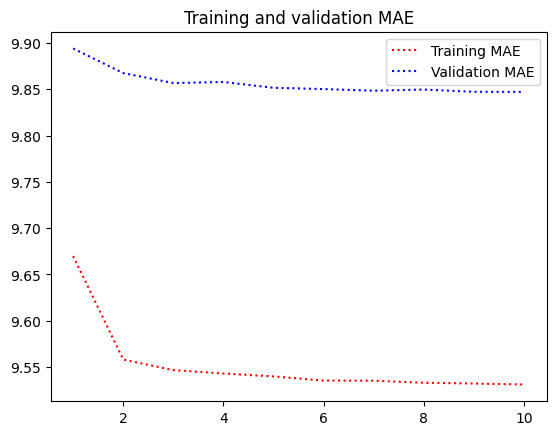

In [31]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**After 2 epochs the model has stopped learning as the MAE is a constant line and converged to a certain level of performance, and further training does not lead to significant improvement, the solution for the above is to experiment with increasing or decreasing the model complexity. We can add more layers, increase the number of units in existing layers, or try different architectures.Trying to add more layers in the data set by stacking the RNN's**

**Simple RNN - Stacking RNN layers**

In [32]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 65s 77ms/step - loss: 136.8222 - mae: 9.5597 - val_loss: 143.3866 - val_mae: 9.8332
Epoch 2/10
819/819 [==============================] - 60s 74ms/step - loss: 135.8913 - mae: 9.5072 - val_loss: 143.3875 - val_mae: 9.8301
Epoch 3/10
819/819 [==============================] - 63s 77ms/step - loss: 135.8607 - mae: 9.5029 - val_loss: 143.3752 - val_mae: 9.8269
Epoch 4/10
819/819 [==============================] - 61s 74ms/step - loss: 135.8499 - mae: 9.5001 - val_loss: 143.3871 - val_mae: 9.8342
Epoch 5/10
819/819 [==============================] - 60s 73ms/step - loss: 135.8290 - mae: 9.4968 - val_loss: 143.4139 - val_mae: 9.8360
Epoch 6/10
819/819 [==============================] - 60s 74ms/step - loss: 135.8199 - mae: 9.4948 - val_loss: 143.3855 - val_mae: 9.8322
Epoch 7/10
819/819 [==============================] - 62s 76ms/step - loss: 135.8107 - mae: 9.4939 - val_loss: 143.3664 - val_mae: 9.8310
Epoch 8/10
819/819 [==============

In [33]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 120, 16)           496       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 120, 16)           528       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16)                528       
                                                                 
Total params: 1552 (6.06 KB)
Trainable params: 1552 (6.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


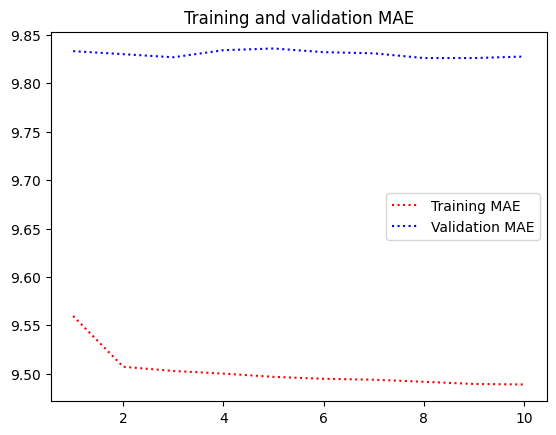

In [35]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**The Traing and Validation MAE seems to be a constant line which indicates that the model is unable to capture the underlying patterns in the data**

**Simple GRU (Gated Recurrent Unit)**

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 39.6884 - mae: 4.5892 - val_loss: 12.4447 - val_mae: 2.6560
Epoch 2/10
819/819 [==============================] - 48s 59ms/step - loss: 10.6058 - mae: 2.5354 - val_loss: 10.1136 - val_mae: 2.4345
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 9.6392 - mae: 2.4249 - val_loss: 10.2209 - val_mae: 2.4306
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 9.2633 - mae: 2.3740 - val_loss: 10.0337 - val_mae: 2.4168
Epoch 5/10
819/819 [==============================] - 48s 59ms/step - loss: 9.0122 - mae: 2.3426 - val_loss: 9.3895 - val_mae: 2.3533
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 8.7764 - mae: 2.3118 - val_loss: 10.1925 - val_mae: 2.4283
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 8.5833 - mae: 2.2843 - val_loss: 10.3672 - val_mae: 2.4493
Epoch 8/10
819/819 [==============================] - 

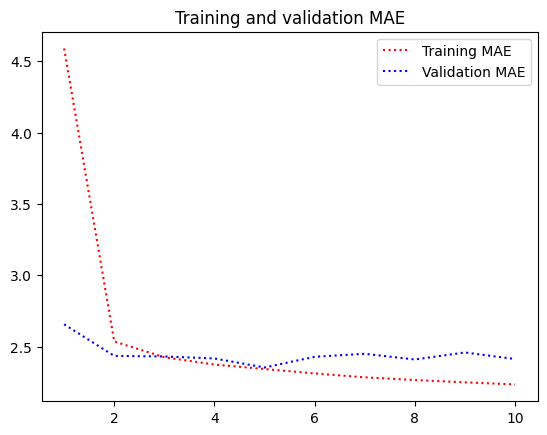

In [37]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**LSTM-Simple is a simplified version of the Long Short-Term Memory (LSTM) network architecture**

In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 61ms/step - loss: 35.8050 - mae: 4.3459 - val_loss: 11.3106 - val_mae: 2.5689
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 10.8630 - mae: 2.5701 - val_loss: 9.5216 - val_mae: 2.3905
Epoch 3/10
819/819 [==============================] - 49s 60ms/step - loss: 9.9253 - mae: 2.4577 - val_loss: 9.5053 - val_mae: 2.3828
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 9.3554 - mae: 2.3868 - val_loss: 9.3046 - val_mae: 2.3618
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 8.8589 - mae: 2.3272 - val_loss: 9.6976 - val_mae: 2.4145
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 8.5793 - mae: 2.2927 - val_loss: 9.3541 - val_mae: 2.3758
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 8.3801 - mae: 2.2662 - val_loss: 9.6553 - val_mae: 2.4112
Epoch 8/10
819/819 [==============================] - 48s 5

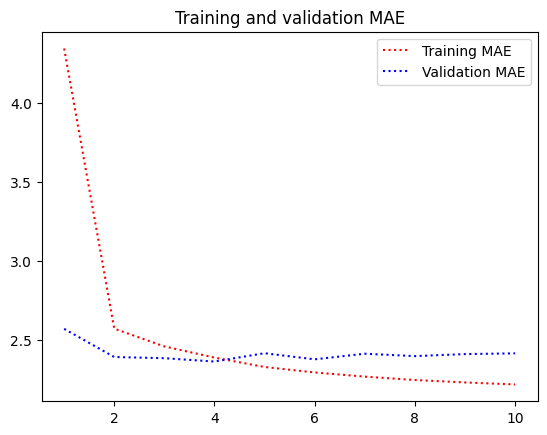

In [39]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**LSTM (RNN) - dropout Regularization that is widely used for tasks involving sequential data, such as natural language processing and time series analysis. LSTM networks are designed to capture long-term dependencies in data**

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 67s 80ms/step - loss: 51.6764 - mae: 5.3606 - val_loss: 14.2691 - val_mae: 2.8403
Epoch 2/10
819/819 [==============================] - 66s 81ms/step - loss: 19.9494 - mae: 3.4315 - val_loss: 10.0053 - val_mae: 2.4498
Epoch 3/10
819/819 [==============================] - 65s 79ms/step - loss: 18.0009 - mae: 3.2650 - val_loss: 9.5284 - val_mae: 2.3998
Epoch 4/10
819/819 [==============================] - 65s 80ms/step - loss: 17.1562 - mae: 3.1841 - val_loss: 9.3246 - val_mae: 2.3757
Epoch 5/10
819/819 [==============================] - 62s 76ms/step - loss: 16.4754 - mae: 3.1261 - val_loss: 9.5116 - val_mae: 2.3993
Epoch 6/10
819/819 [==============================] - 65s 79ms/step - loss: 16.0095 - mae: 3.0782 - val_loss: 9.3899 - val_mae: 2.3852
Epoch 7/10
819/819 [==============================] - 62s 76ms/step - loss: 15.5427 - mae: 3.0388 - val_loss: 9.5106 - val_mae: 2.3948
Epoch 8/10
819/819 [==============================] -

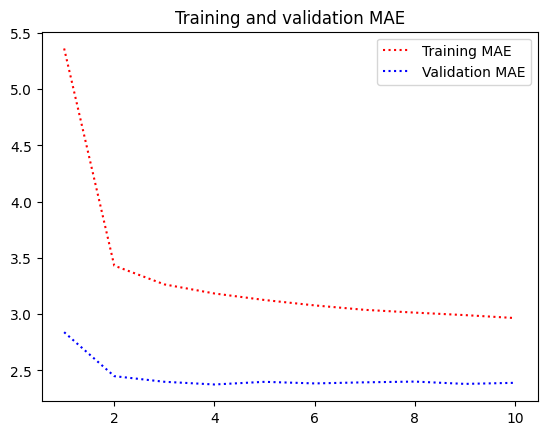

In [41]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Stacked LSTM setup involves using multiple LSTM layers stacked on top of each other in a neural network. Each LSTM layer captures different levels of abstraction in the input data, allowing for more powerful modeling of sequential information.**

**8 UNITS**

In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 83s 97ms/step - loss: 74.0988 - mae: 6.6060 - val_loss: 38.4603 - val_mae: 4.6196
Epoch 2/10
819/819 [==============================] - 78s 95ms/step - loss: 22.7132 - mae: 3.5096 - val_loss: 13.6088 - val_mae: 2.7576
Epoch 3/10
819/819 [==============================] - 80s 97ms/step - loss: 11.4718 - mae: 2.6127 - val_loss: 9.6877 - val_mae: 2.4064
Epoch 4/10
819/819 [==============================] - 82s 100ms/step - loss: 10.0872 - mae: 2.4637 - val_loss: 9.5800 - val_mae: 2.4089
Epoch 5/10
819/819 [==============================] - 75s 91ms/step - loss: 9.6417 - mae: 2.4138 - val_loss: 9.5825 - val_mae: 2.4142
Epoch 6/10
819/819 [==============================] - 83s 102ms/step - loss: 9.4248 - mae: 2.3901 - val_loss: 9.4303 - val_mae: 2.3872
Epoch 7/10
819/819 [==============================] - 77s 93ms/step - loss: 9.2501 - mae: 2.3728 - val_loss: 9.6501 - val_mae: 2.4115
Epoch 8/10
819/819 [==============================] - 

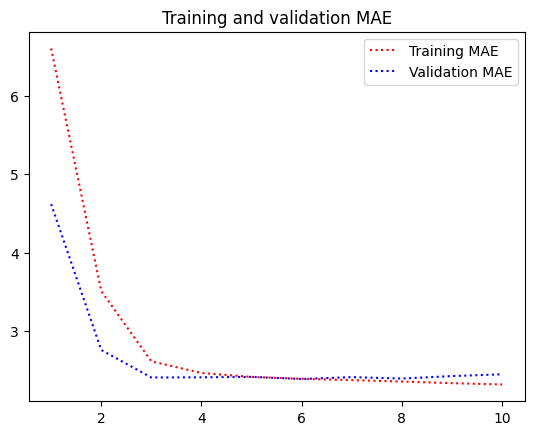

In [43]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**16 UNITS**

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 98s 116ms/step - loss: 42.0738 - mae: 4.7110 - val_loss: 12.8512 - val_mae: 2.6901
Epoch 2/10
819/819 [==============================] - 100s 122ms/step - loss: 10.4732 - mae: 2.5063 - val_loss: 9.9261 - val_mae: 2.4599
Epoch 3/10
819/819 [==============================] - 104s 127ms/step - loss: 9.2709 - mae: 2.3705 - val_loss: 9.8979 - val_mae: 2.3877
Epoch 4/10
819/819 [==============================] - 97s 119ms/step - loss: 8.6948 - mae: 2.3002 - val_loss: 10.6202 - val_mae: 2.4846
Epoch 5/10
819/819 [==============================] - 92s 112ms/step - loss: 8.3354 - mae: 2.2578 - val_loss: 10.1413 - val_mae: 2.4742
Epoch 6/10
819/819 [==============================] - 89s 108ms/step - loss: 7.7921 - mae: 2.1842 - val_loss: 10.5327 - val_mae: 2.5227
Epoch 7/10
819/819 [==============================] - 97s 119ms/step - loss: 7.5107 - mae: 2.1411 - val_loss: 10.4613 - val_mae: 2.5379
Epoch 8/10
819/819 [==========================

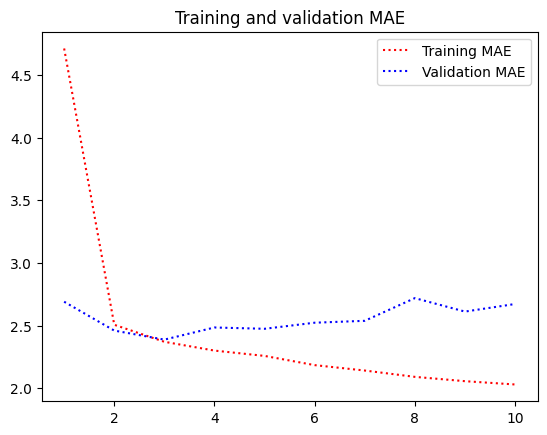

In [45]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**32 UNITS**

In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 147s 177ms/step - loss: 19.0945 - mae: 3.1579 - val_loss: 10.1654 - val_mae: 2.4819
Epoch 2/10
819/819 [==============================] - 144s 175ms/step - loss: 7.8713 - mae: 2.1824 - val_loss: 10.2625 - val_mae: 2.5212
Epoch 3/10
819/819 [==============================] - 144s 176ms/step - loss: 6.3542 - mae: 1.9552 - val_loss: 11.2442 - val_mae: 2.6375
Epoch 4/10
819/819 [==============================] - 145s 176ms/step - loss: 5.3425 - mae: 1.7900 - val_loss: 12.8239 - val_mae: 2.8244
Epoch 5/10
819/819 [==============================] - 144s 175ms/step - loss: 4.5091 - mae: 1.6403 - val_loss: 12.4676 - val_mae: 2.7854
Epoch 6/10
819/819 [==============================] - 146s 178ms/step - loss: 3.9774 - mae: 1.5355 - val_loss: 12.9631 - val_mae: 2.8416
Epoch 7/10
819/819 [==============================] - 142s 174ms/step - loss: 3.5503 - mae: 1.4502 - val_loss: 13.3688 - val_mae: 2.8698
Epoch 8/10
819/819 [====================

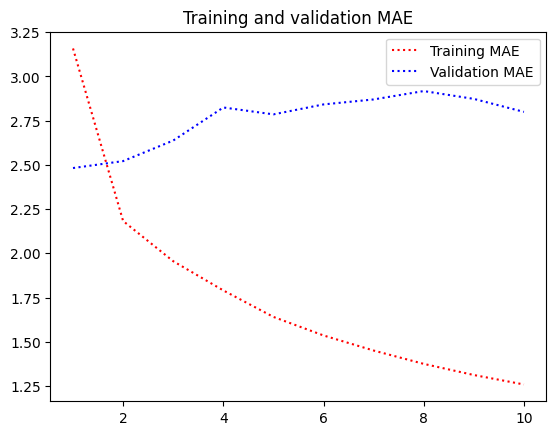

In [47]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**64 UNITS**

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked4.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked4.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 317s 383ms/step - loss: 12.8176 - mae: 2.6490 - val_loss: 9.8853 - val_mae: 2.4510
Epoch 2/10
819/819 [==============================] - 308s 376ms/step - loss: 5.2434 - mae: 1.7690 - val_loss: 11.8982 - val_mae: 2.7000
Epoch 3/10
819/819 [==============================] - 307s 375ms/step - loss: 3.2590 - mae: 1.3820 - val_loss: 12.7152 - val_mae: 2.8100
Epoch 4/10
819/819 [==============================] - 307s 375ms/step - loss: 2.3538 - mae: 1.1661 - val_loss: 13.3400 - val_mae: 2.8648
Epoch 5/10
819/819 [==============================] - 308s 376ms/step - loss: 1.7464 - mae: 1.0048 - val_loss: 13.4094 - val_mae: 2.8861
Epoch 6/10
819/819 [==============================] - 307s 375ms/step - loss: 1.4155 - mae: 0.9009 - val_loss: 13.2885 - val_mae: 2.8794
Epoch 7/10
819/819 [==============================] - 308s 376ms/step - loss: 1.1944 - mae: 0.8258 - val_loss: 13.4627 - val_mae: 2.8969
Epoch 8/10
819/819 [=====================

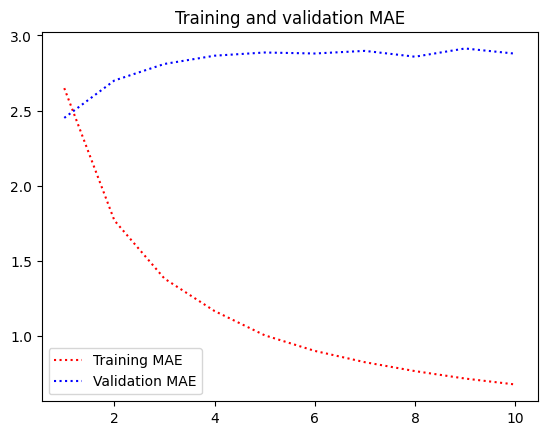

In [49]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**LSTM - dropout-regularized, stacked model**

In [50]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.st",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 125s 146ms/step - loss: 78.8921 - mae: 6.8562 - val_loss: 39.6242 - val_mae: 4.6914
Epoch 2/10
819/819 [==============================] - 120s 146ms/step - loss: 33.2401 - mae: 4.2907 - val_loss: 14.5829 - val_mae: 2.8464
Epoch 3/10
819/819 [==============================] - 121s 148ms/step - loss: 24.7439 - mae: 3.7514 - val_loss: 10.8225 - val_mae: 2.5096
Epoch 4/10
819/819 [==============================] - 119s 145ms/step - loss: 22.6022 - mae: 3.5954 - val_loss: 10.5287 - val_mae: 2.5038
Epoch 5/10
819/819 [==============================] - 116s 142ms/step - loss: 21.2123 - mae: 3.4843 - val_loss: 10.5945 - val_mae: 2.5215
Epoch 6/10
819/819 [==============================] - 120s 146ms/step - loss: 20.2018 - mae: 3.4098 - val_loss: 9.6699 - val_mae: 2.4177
Epoch 7/10
819/819 [==============================] - 116s 141ms/step - loss: 19.3632 - mae: 3.3387 - val_loss: 9.8090 - val_mae: 2.4378
Epoch 8/10
819/819 [================

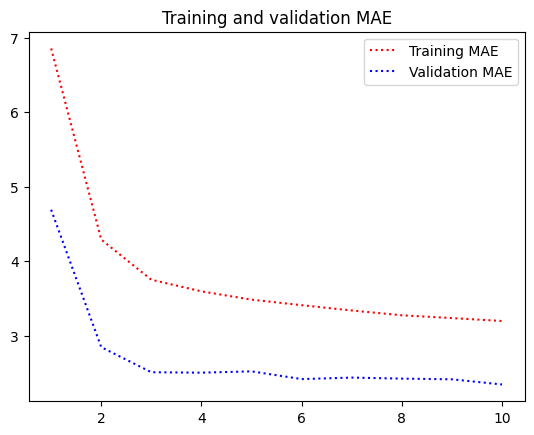

In [51]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Bi Directional LSTM**

In [52]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.st",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 67s 79ms/step - loss: 25.8605 - mae: 3.6484 - val_loss: 10.8404 - val_mae: 2.5605
Epoch 2/10
819/819 [==============================] - 63s 76ms/step - loss: 9.3113 - mae: 2.3761 - val_loss: 9.6838 - val_mae: 2.4198
Epoch 3/10
819/819 [==============================] - 62s 76ms/step - loss: 8.4761 - mae: 2.2676 - val_loss: 9.3381 - val_mae: 2.3664
Epoch 4/10
819/819 [==============================] - 65s 79ms/step - loss: 7.9475 - mae: 2.1961 - val_loss: 9.2350 - val_mae: 2.3583
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 7.5249 - mae: 2.1391 - val_loss: 9.7053 - val_mae: 2.4056
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 7.1846 - mae: 2.0894 - val_loss: 10.1662 - val_mae: 2.4503
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 6.9042 - mae: 2.0449 - val_loss: 10.3305 - val_mae: 2.4739
Epoch 8/10
819/819 [==============================] - 54s 

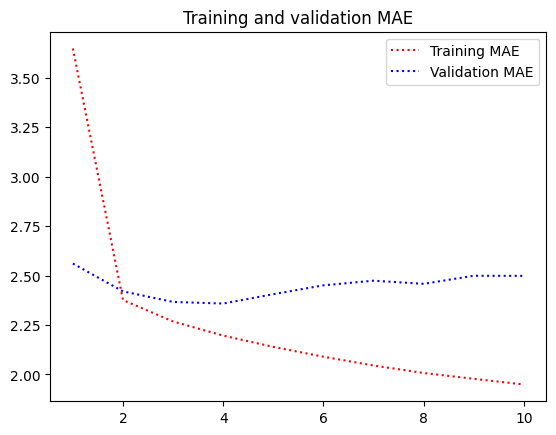

In [53]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM togther**

In [54]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.st", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.st")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 20s 23ms/step - loss: 43.4821 - mae: 4.9225 - val_loss: 25.7789 - val_mae: 4.0036
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 17.0225 - mae: 3.1892 - val_loss: 23.8101 - val_mae: 3.8021
Epoch 3/10
819/819 [==============================] - 17s 20ms/step - loss: 14.0592 - mae: 2.9062 - val_loss: 23.4863 - val_mae: 3.8955
Epoch 4/10
819/819 [==============================] - 17s 20ms/step - loss: 12.4729 - mae: 2.7292 - val_loss: 22.6408 - val_mae: 3.7747
Epoch 5/10
819/819 [==============================] - 18s 22ms/step - loss: 11.4156 - mae: 2.6011 - val_loss: 21.5948 - val_mae: 3.7190
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 10.5713 - mae: 2.4969 - val_loss: 22.3032 - val_mae: 3.7504
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 9.8649 - mae: 2.4054 - val_loss: 23.6505 - val_mae: 3.8888
Epoch 8/10
819/819 [=============================

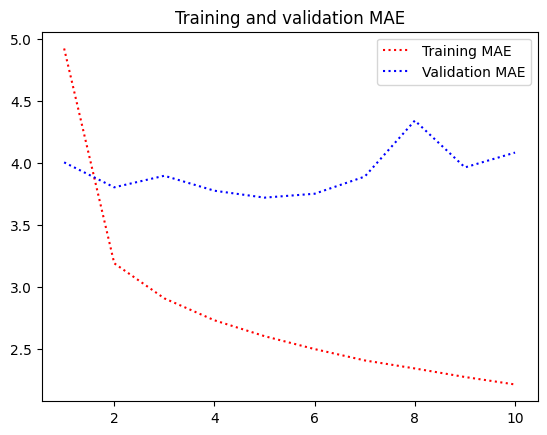

In [55]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()

# Update the color to red and line style to a dotted line for training MAE
plt.plot(epochs, loss, "r:", label="Training MAE")

# Update the color to blue and line style to a dotted line for validation MAE
plt.plot(epochs, val_loss, "b:", label="Validation MAE")

plt.title("Training and validation MAE")
plt.legend()
plt.show()


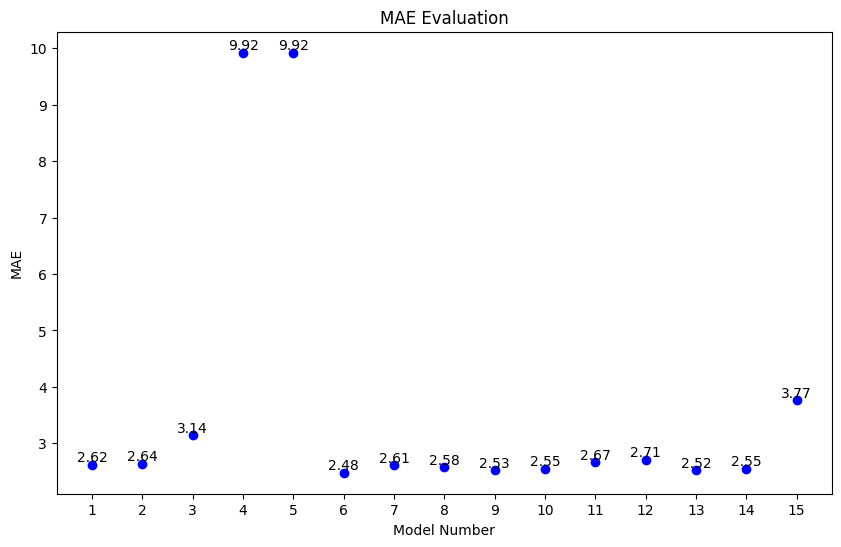

In [57]:
import matplotlib.pyplot as plt
import numpy as np

Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15")
Mae = (2.62,2.64,3.14,9.92,9.92,2.48,2.61,2.58,2.53,2.55,2.67,2.71,2.52,2.55,3.77)

# MAE Evaluation
plt.figure(figsize=(10, 6))
plt.scatter(Models, Mae, color="blue")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()
